In [121]:
import pandas as pd
import numpy as np

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt

In [12]:
nltk.download('stopwords');
nltk.download('punkt');
nltk.download('wordnet');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...


In [93]:
file_path = "../Data/spam_dataset.csv"

df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [94]:
df = df[['Body', 'Label']]
df.columns = ['message_content', 'is_spam']

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   message_content  6045 non-null   object
 1   is_spam          6046 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 94.6+ KB


In [101]:
df.dropna(inplace = True)
df.is_spam.value_counts()

is_spam
0    4150
1    1895
Name: count, dtype: int64

In [102]:
stop_words = set(stopwords.words('english'))

In [103]:
lemmatizer = WordNetLemmatizer()

In [104]:
def preprocess_text(text):
    
    text = text.lower()
    
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d', ' ', text)
    
    tokens = word_tokenize(text)
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [105]:
df['cleaned_message'] = df['message_content'].apply(preprocess_text)

In [106]:
df.head()

,message_content,is_spam,cleaned_message
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,save life insurance spend life quote saving en...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,fight risk cancer http www adclick w p cfm pk ...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,fight risk cancer http www adclick w p cfm pk ...
3,##############################################...,1,adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,1,thought might like slim guaranteed lose lb day...


In [107]:
vectorizer = TfidfVectorizer(max_features = 5000)

X = vectorizer.fit_transform(df['cleaned_message']).toarray()
y = df['is_spam']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y)

In [125]:
ros = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(y_train_resampled.value_counts())

is_spam
0    3320
1    1516
Name: count, dtype: int64
is_spam
1    3320
0    3320
Name: count, dtype: int64


In [127]:
# Entrenar un modelo Naive Bayes
model = MultinomialNB()
model

MultinomialNB()

In [128]:
model.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [129]:
# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

In [130]:
# Evaluar el rendimiento del modelo
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9503722084367245


In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       830
           1       0.87      0.98      0.93       379

    accuracy                           0.95      1209
   macro avg       0.93      0.96      0.94      1209
weighted avg       0.96      0.95      0.95      1209



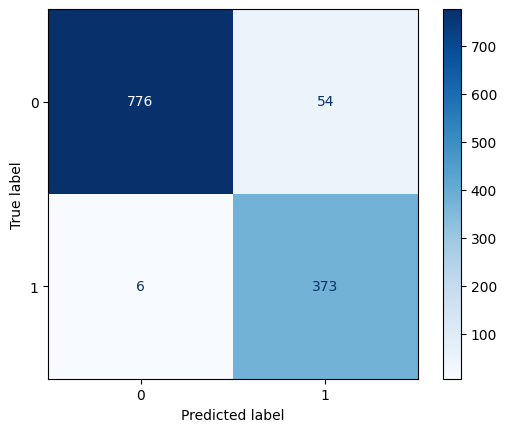

In [132]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.show()

In [133]:
# Obtener las probabilidades de predicción para la clase positiva (spam)
y_prob = model.predict_proba(X_test)[:, 1]

In [134]:
# Calcular la curva ROC y el AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

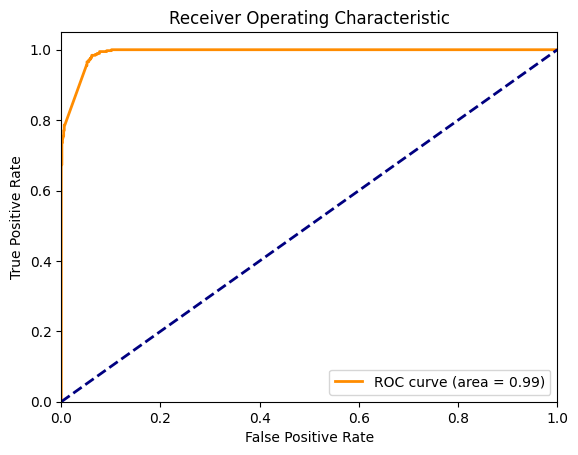

In [135]:
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()